# Autproductie

## Overzicht
We kijken naar de dataset `cars.csv`, deze bevat informatie over de verkoop van 2e hands Volvo’s. We hebben hier een aantal vragen over, beantwoord deze vragen door een beetje code te schrijven en de antwoorden op te schrijven in een Jupyter Notebook.

In [1]:
# importeer libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

In [2]:
# importeer dataset
df_cars = pd.read_csv(os.path.join('..', 'data', 'input', 'cars.csv'))

In [3]:
# importeer functies
sys.path.append('../scripts')  # definieer path met scripts
from fuel_mappings import fuel_mapping
from make_a_chart import horizontal_bar_chart

In [31]:
# Maak een kopie van het originele dataframe
original_df = df_cars.copy()

# print(df_cars.sample(3))

### Vraag 1:
Wat voor soort data zijn `year`, `fuel_type` en `seller_rating`? Motiveer je antwoord.

Antwoord:

**year**: numeriek (meer specifiek: integer)

**fuel_type**: categorisch (meer specifiek: niet-ordinaal, er is geen rangorde tussen deze categorieën)

**seller_rating**: kan zowel numeriek (meer specifiek: float, incl. potentiële NaN's) als categorisch (meer specifiek: ordinaal) geinterpreteerd worden, dit hangt af van de businessvraag.

In [32]:
# lijst van types
print(df_cars.loc[:,['year', 'fuel_type', 'seller_rating']].dtypes)

# enkele sample data
print(df_cars.loc[:,['year', 'fuel_type', 'seller_rating']].sample(3))

year               int64
fuel_type         object
seller_rating    float64
dtype: object
        year fuel_type  seller_rating
342755  2016  Gasoline            NaN
121037  2019  Gasoline            NaN
189925  2019  Gasoline            4.5


### Vraag 2:
Ik vraag me af hoe een gewoonlijke (mbt prijs) $2^e$ hands Volvo eruit ziet. Kan je deze zoeken en tonen?

Antwoord: Zonder gedetailleerd naar de prijzen te kijken is de mediaan de veiligste centrummaat. Bij Vraag 3 kijken we ook naar andere centrummaten.

In [33]:
# Bereken mediaan price
median_price_volvo = (df_cars[df_cars['manufacturer'] == 'Volvo']
                   ['price'].median()
                  )
print(f"Mediaanprijs van een 2de hands Volvo: {round(median_price_volvo)}")

Mediaanprijs van een 2de hands Volvo: 36677


In [34]:
# Toon alle Volvo's met mediaan prijs
volvo_median_price = df_cars[(df_cars['price'] == median_price_volvo)
                         & (df_cars['manufacturer'] == 'Volvo')]

volvo_median_price.T

""
manufacturer
model
year
mileage
engine
transmission
drivetrain
fuel_type
mpg
exterior_color


### Vraag 3:
We kunnen de verdeling van de prijs van $2^e$ hands Volvo's voorstellen met een histogram:
 - Waar zou je verwachten dat het gemiddelde +/- ligt voor deze verdeling?
 - Waar zou je verwachten dat de mediaan +/- ligt?

Teken dit histogram met `.hist` en gebruik `.axvline` om de mediaan en het gemiddelde toe te voegen aan de plot. Komt dit overeen met je verwachting?

 - Kan je de emprisiche cumulatieve distributie functie tekenen voor de verdeling die overeenkomt met dit histogram (zie ook `scipy.stats.ecdf`).

In [9]:
# Berekening gemiddelde prijs van een 2de hands Volvo
avg_price_volvo = (df_cars[df_cars['manufacturer'] == 'Volvo']
                   ['price'].mean()
                  )

In [10]:
# conda install matplotlib=3.8

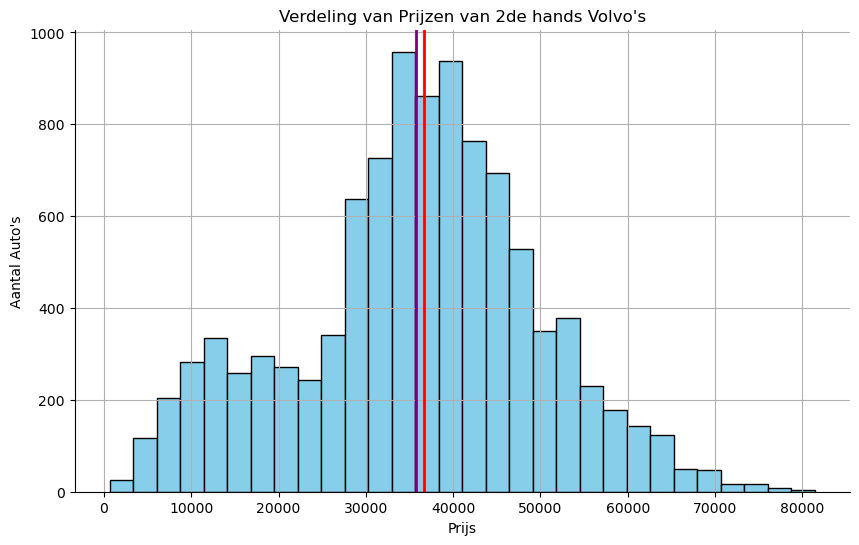

In [11]:
# Histogram van prijzen
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_cars[df_cars['manufacturer'] == 'Volvo']['price'], bins=30, color='skyblue', edgecolor='black')
ax.set_title("Verdeling van Prijzen van 2de hands Volvo's")
ax.set_xlabel('Prijs')
ax.set_ylabel("Aantal Auto's")

# Voeg verticale lijnen toe voor mediaan (rood) en gemiddelde (paars)
ax.axvline(median_price_volvo, color='red', linestyle='solid', linewidth=2, label='Mediaan')
ax.axvline(avg_price_volvo, color='purple', linestyle='solid', linewidth=2, label='Gemiddelde')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show grid
ax.grid(True)
plt.show()

Uit de grafiek leiden we af dat de prijsverdeling min of meer symmetrisch is, weliswaar met een iets zwaardere linkerkant. De linkerkant zal maken dat het gemiddelde lager zal zijn dan de mediaan, en dit wordt ook door de berekeningen bevestigd.

### Vraag 4:
Ik wil nu de verschillende fuel types vergelijken hoeveel deze kosten. Hiervoor maak ik volgende afbeelding met meerdere histogrammen hoe kunnen we deze beter maken? Welke alternatieven zijn er nog?

Antwoord: Er zijn veel meer 2de hands Volvo's met Gasoline dan met andere brandstoffen. Een vergelijking obv histogrammen (met absolute aantallen) is moeilijk te maken. Laat ons eerst eens kijken van welke brandstoftypes we voldoende data hebben om een inschatting te maken van het aandeel wagens per prijscategorie.

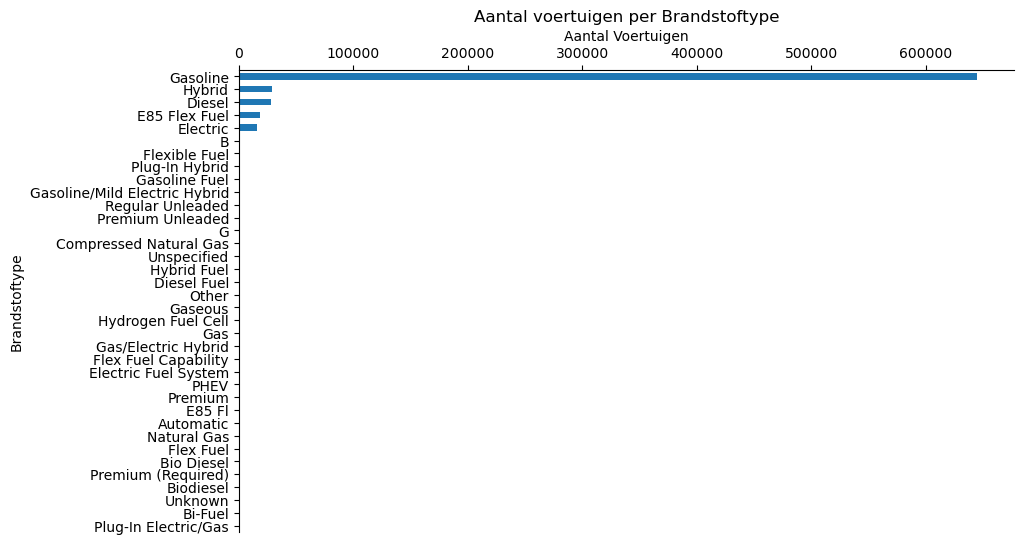

In [12]:
# Aantal voertuigen per fuel_type, gesorteerd van hoog naar laag
fuel_type_counts = df_cars['fuel_type'].value_counts(ascending=True)

# Use the function to create a horizontal bar chart for the 'fuel_type' column
horizontal_bar_chart(df_cars, 'fuel_type', 'Aantal voertuigen per Brandstoftype', 'Aantal Voertuigen', 'Brandstoftype')

Het lijkt erop dat niet elke wagen binnen 1 van de hoofdcategorieën werd geclassificeerd. Om een idee te krijgen van de grootte van het probleem, berekenen we het aandeel 'verkeerde' registraties:

In [28]:
# Bereken het totale aantal voertuigen
total_vehicles = df_cars['fuel_type'].count()

# Selecteer de top 5 hoofdcategorieën
top_5_categories = fuel_type_counts.nlargest(5)

# Bereken het aandeel van elk van de 5 hoofdcategorieën
share_of_categories = (top_5_categories / total_vehicles) * 100

print("Aandeel van elk van de 5 hoofdcategorieën:")
print(share_of_categories)

# Bereken de som van de aandelen van de eerste 5 categorieën
sum_of_top_5_categories = share_of_categories.sum()

print("Som van de aandelen van de eerste 5 categorieën:", round(sum_of_top_5_categories, 2), "%")

Aandeel van elk van de 5 hoofdcategorieën:
fuel_type
Gasoline         87.396558
Hybrid            3.950743
Diesel            3.791580
E85 Flex Fuel     2.544983
Electric          2.195204
Name: count, dtype: float64
Som van de aandelen van de eerste 5 categorieën: 99.88 %


We concluderen hieruit dat het aantal voertuigen met 'verkeerde' info over brandstoftype verwaarloosbaar klein is. We verfijnen het veld fuel_type door een categorisatie te maken. De groep met verkeerde info over brandstoftype 'Others' nemen we niet mee in de rest van onze analyse.

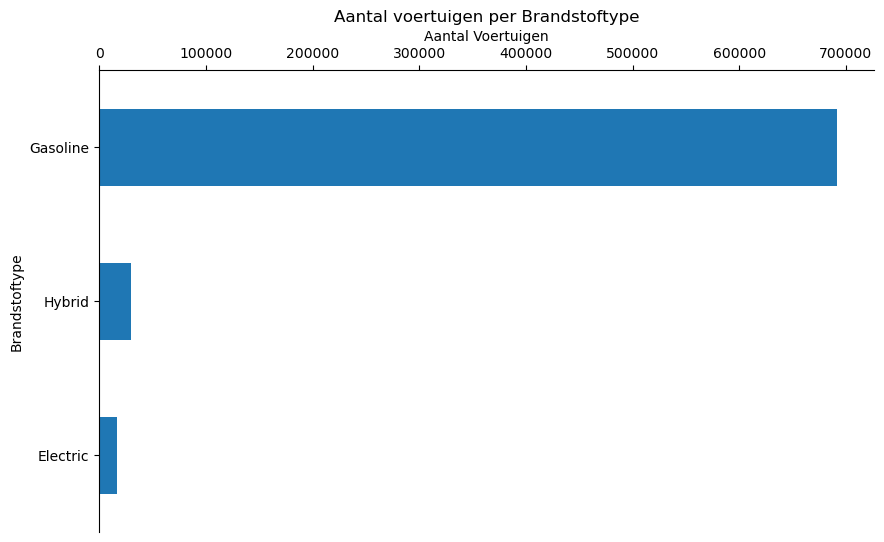

In [30]:
# Map fuel types using the fuel_mapping dictionary
df_cars['mapped_fuel_type'] = df_cars['fuel_type'].map(fuel_mapping)

# Use the function to create a horizontal bar chart for the 'mapped_fuel_type' column
horizontal_bar_chart(df_cars, 'mapped_fuel_type', 'Aantal voertuigen per Brandstoftype', 'Aantal Voertuigen', 'Brandstoftype')

In [15]:
# Filter out rows where the mapped fuel type is 'Other'
df_cars = df_cars[df_cars['mapped_fuel_type'] != 'Other']

### Vraag 5:
Gegeven volgende boxplots van de prijs van elektrische & benzine wagens, zijn volgende uitspraken waar/onwaar/niet te besluiten & leg uit:

![alt text](image-2.png)

 - De spreiding op de prijs van elektrische wagens is groter dan die van benzinewagens.

 - Een wagen die meer dan 50 000 euro kost heeft een grotere kans om elektrisch te zijn dan benzine.

 - Een elektrische wagen heeft een grotere kans om meer dan 50 000 euro te kosten dan een benzine wagen.

Antwoord:
- waar: de afstand min-max is groter bij benzinewagens, vergeleken met electrische wagens
- niet te besluiten: boxplots geven geen informatie over het aantal elektrische wagens vergeleken met het aantal benzinewagens
- waar: Bij benzinewagens ligt 75ste percentiel ongeveer op 50 000 euro. Bij elektrische wagens ligt mediaan net onder 50 000 euro, wat betekent dat iets minder dan de helft van de wagens meer kosten. Bij benzine ligt 75ste percentiel ongeveer op 50 000, waardoor het aandeel benzinewagens +50 000 minder zal zijn dan het aandeel elektrische wagens +50 000.

### Vraag 6:
Maak een visualizatie om het verband tussen mileage & price te tonen?

In [ ]:
# np.max(df_cars.mileage)
# np.max(df_cars.price)

In [ ]:
# filter outliers op vlak van prijs en mileage weg
df_cars = df_cars[df_cars.price < 1000000]
df_cars = df_cars[df_cars.mileage < 500000]

# creËer scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_cars.mileage, df_cars.price, color='skyblue', label='Data Points')

# voeg labels en titel toe
plt.title('Correlation Mileage and Price')
plt.xlabel('Mileage (miles)')
plt.ylabel('Price ($)')

# voeg trendlijn toe
z = np.polyfit(df_cars.mileage, df_cars.price, 1)
p = np.poly1d(z)
plt.plot(mileage, p(mileage), color='red', label='Trend Line')

# Voeg limieten voor x en y assen op basis van de datarange
plt.xlim(np.min(df_cars.mileage) - 1000, np.max(df_cars.mileage) + 1000)
plt.ylim(np.min(df_cars.price) - 1000, np.max(df_cars.price) + 1000)

# Voeg legende toe
plt.legend()

plt.grid(True)
plt.show()

### Vraag 7:
Volgens deze data is de gemiddelde prijs van $2^e$ hands elektrische Volvo’s 48 000 euro; als we veronderstellen dat onze dataset representatief is voor alle 2de hands volvo’s, hoe kan je de accuraatheid van deze schatting nagaan?